In [1]:
from fit.datamodules.super_res.SRecDataModule import CelebASResFourierTargetDataModule
from fit.utils import convert2FC
from fit.utils.tomo_utils import get_img_coords_pol

from fit.modules.SResTransformerModule import SResTransformerModule

from matplotlib import pyplot as plt

import torch

import numpy as np

from pytorch_lightning import Trainer, seed_everything
from pytorch_lightning.callbacks import ModelCheckpoint

from matplotlib import rc
from tqdm.notebook import tqdm

from matplotlib import gridspec

In [2]:
seed_everything(22122020)

22122020

In [3]:
dm = CelebASResFourierTargetDataModule(root_dir='/data/celeb/', batch_size=1)
dm.setup()

In [4]:
r, phi, flatten_order, order = get_img_coords_pol(img_shape=dm.gt_shape, det_len=dm.gt_shape)

In [5]:
n_heads = 8
d_query = 32

In [6]:
model = SResTransformerModule(d_model=n_heads*d_query, 
                              img_shape=dm.gt_shape,
                              y_coords_img=r,
                              x_coords_img=phi,
                              dst_flatten_order=flatten_order,
                              dst_order=order,
                              loss='prod',
                              lr=0.0001, weight_decay=0.01, n_layers=8,
                              n_heads=n_heads, d_query=d_query, dropout=0.1, attention_dropout=0.1)

In [7]:
model.load_test_model('/home/tbuchhol/HaarVAE/FIT_experiments/iccv_experiments/CelebA_SRes/version_8/checkpoints/best_val_loss_-epoch=66-step=41874.ckpt')

In [8]:
len(dm.test_dataloader())

5000

In [9]:
dm.batch_size = 5000

In [10]:
for fc, (mag_min, mag_max) in dm.test_dataloader():
    break

In [11]:
dm.gt_shape // 4 + 1

16

In [12]:
x, y = np.meshgrid(range(model.dft_shape[1]), range(-model.dft_shape[0] // 2, model.dft_shape[0] // 2))
radii = np.roll(np.sqrt(x ** 2 + y ** 2, dtype=np.float32), model.dft_shape[0] // 2, 0)
num_shells = 16
model.input_seq_length = np.sum(np.round(radii) < num_shells)

In [13]:
model = model.cuda()

In [14]:
x_fc = fc[:, model.dst_flatten_order][:, :model.input_seq_length]
pred_fc = model.predict_with_recurrent(x_fc.cuda(), model.input_seq_length, fc.shape[1])
# pred_img = model.convert2img(fc=pred_fc, mag_min=mag_min, mag_max=mag_max)

/home/tbuchhol/.local/lib/python3.7/site-packages/torch/nn/functional.py:1628: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


In [15]:
lowres, pred_img, gt = model.get_lowres_pred_gt(fc.cuda(), mag_min.cuda(), mag_max.cuda())

In [16]:
pred_fc = pred_fc.detach().cpu()
lowres = lowres.detach().cpu()
pred_img = pred_img.detach().cpu()
gt = gt.detach().cpu()

In [17]:
x, y = np.meshgrid(range(model.dft_shape[1]), range(-model.dft_shape[0] // 2, model.dft_shape[0] // 2))
radii = np.roll(np.sqrt(x ** 2 + y ** 2, dtype=np.float32), model.dft_shape[0] // 2, 0)
index = np.round(radii)

In [18]:
def FSC(model, a, b, pixel_size=1, threshold=0.5):
    fft_a = torch.fft.rfftn(a)
    fft_b = torch.fft.rfftn(b)
    AB = torch.multiply(fft_a, torch.conj(fft_b))
    AA = torch.multiply(fft_a, torch.conj(fft_a))
    BB = torch.multiply(fft_b, torch.conj(fft_b))

    x, y = torch.meshgrid(torch.arange(-model.dft_shape[0] // 2, model.dft_shape[0] // 2, dtype=torch.float32), torch.arange(model.dft_shape[1], dtype=torch.float32))
    radii = torch.roll(torch.sqrt(x ** 2 + y ** 2), model.dft_shape[0] // 2, 0)
    index = torch.round(radii)

    AB_ = []
    AA_ = []
    BB_ = []
    for i in range(model.dft_shape[1]):
        indices = torch.where(index == i)
        AB_.append(sum(AB[indices])/len(indices[0]))
        AA_.append(sum(AA[indices])/len(indices[0]))
        BB_.append(sum(BB[indices])/len(indices[0]))

    AB_ = torch.tensor(AB_)
    AA_ = torch.tensor(AA_)
    BB_ = torch.tensor(BB_)

    fsc = abs(AB_)/torch.sqrt(abs(torch.multiply(AA_,BB_)))
    x = torch.arange(a.shape[0]/2 + 1)/(a.shape[0]/2) * (1/(pixel_size*2))
    
    def get_idx_above():
        idx = fsc.shape[0]
        for i in range(fsc.shape[0]):
            if fsc[i] < threshold:
                return i - 1
            
    def get_idx_below():
        idx = fsc.shape[0]
        for i in range(fsc.shape[0]):
            if fsc[i] < threshold:
                return i
    
    if torch.any(fsc <= threshold):
        idx_above = get_idx_above()
        idx_below = get_idx_below()
        above_threshold = fsc[idx_above]
        below_threshold = fsc[idx_below]

        frac = (above_threshold - 0.5)/(above_threshold-below_threshold)

        x_above = x[idx_above]
        x_below = x[idx_below]
        one_over_resolution_span = x_above - x_below

        res = ( x_above - one_over_resolution_span * frac)**(-1)
    else:
        res = torch.tensor(float('NaN'))
        
    return fsc, x, res

In [19]:
#rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
rc('font',**{'family':'serif','serif':['Times'], 'size':14})
rc('text', usetex=True)

In [20]:
from fit.utils.utils import denormalize_amp
from fit.utils.tomo_utils import pol2cart

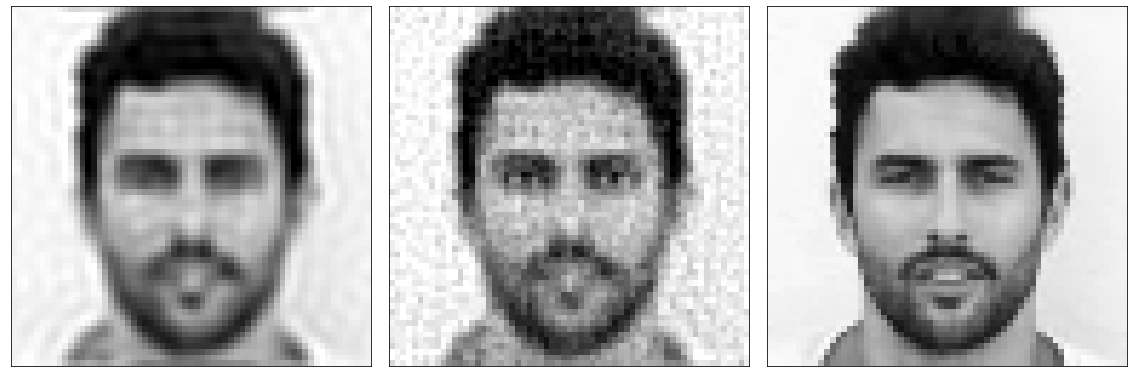

In [21]:
sample = 30

fig = plt.figure(figsize=(31/2., 10/2.)) 
gs = gridspec.GridSpec(1, 5, width_ratios=[10,0.5, 10, 0.5, 10]) 
ax0 = plt.subplot(gs[0])
ax1 = plt.subplot(gs[2])
ax2 = plt.subplot(gs[4])
plt.subplots_adjust(top = 1, bottom = 0, right = 1, left = 0, 
                    hspace = 0, wspace = 0)

ax0.xaxis.set_major_locator(plt.NullLocator())
ax0.yaxis.set_major_locator(plt.NullLocator())
ax0.imshow(lowres[sample], cmap='gray', vmin=gt[sample].min(), vmax=gt[sample].max())
ax0.axis('equal');

ax1.xaxis.set_major_locator(plt.NullLocator())
ax1.yaxis.set_major_locator(plt.NullLocator())
ax1.imshow(pred_img[sample], cmap='gray', vmin=gt[sample].min(), vmax=gt[sample].max())
ax1.axis('equal');


ax2.xaxis.set_major_locator(plt.NullLocator())
ax2.yaxis.set_major_locator(plt.NullLocator())
ax2.imshow(gt[sample], cmap='gray')
ax2.axis('equal');

fig.savefig('figures/sres/{}_celeb_comparison.svg'.format(sample), bbox_inches='tight', pad_inches=0.0)

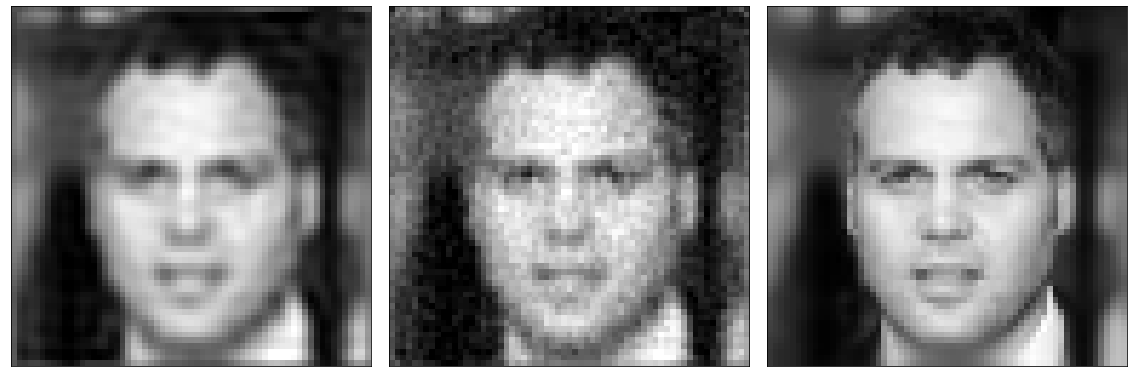

In [22]:
sample = 10

fig = plt.figure(figsize=(31/2., 10/2.)) 
gs = gridspec.GridSpec(1, 5, width_ratios=[10,0.5, 10, 0.5, 10]) 
ax0 = plt.subplot(gs[0])
ax1 = plt.subplot(gs[2])
ax2 = plt.subplot(gs[4])
plt.subplots_adjust(top = 1, bottom = 0, right = 1, left = 0, 
                    hspace = 0, wspace = 0)

ax0.xaxis.set_major_locator(plt.NullLocator())
ax0.yaxis.set_major_locator(plt.NullLocator())
ax0.imshow(lowres[sample], cmap='gray', vmin=gt[sample].min(), vmax=gt[sample].max())
ax0.axis('equal');

ax1.xaxis.set_major_locator(plt.NullLocator())
ax1.yaxis.set_major_locator(plt.NullLocator())
ax1.imshow(pred_img[sample], cmap='gray', vmin=gt[sample].min(), vmax=gt[sample].max())
ax1.axis('equal');


ax2.xaxis.set_major_locator(plt.NullLocator())
ax2.yaxis.set_major_locator(plt.NullLocator())
ax2.imshow(gt[sample], cmap='gray')
ax2.axis('equal');

fig.savefig('figures/sres/{}_celeb_comparison.svg'.format(sample), bbox_inches='tight', pad_inches=0.0)

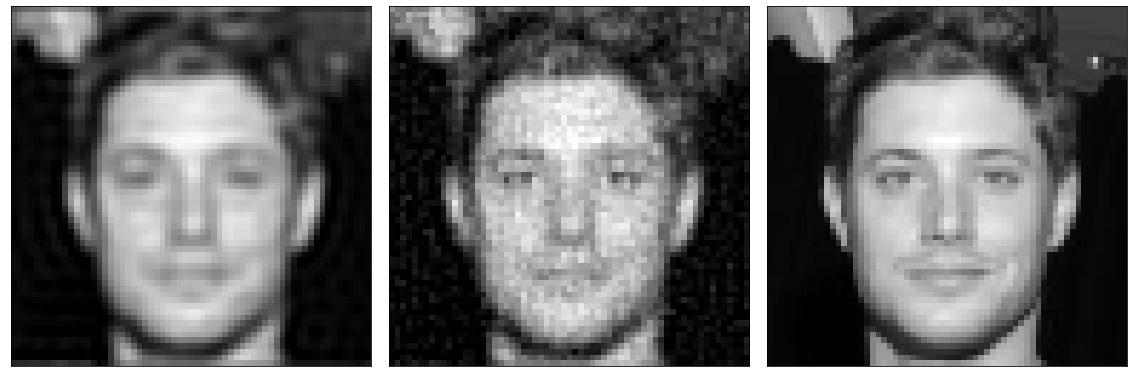

In [23]:
sample = 134

fig = plt.figure(figsize=(31/2., 10/2.)) 
gs = gridspec.GridSpec(1, 5, width_ratios=[10,0.5, 10, 0.5, 10]) 
ax0 = plt.subplot(gs[0])
ax1 = plt.subplot(gs[2])
ax2 = plt.subplot(gs[4])
plt.subplots_adjust(top = 1, bottom = 0, right = 1, left = 0, 
                    hspace = 0, wspace = 0)

ax0.xaxis.set_major_locator(plt.NullLocator())
ax0.yaxis.set_major_locator(plt.NullLocator())
ax0.imshow(lowres[sample], cmap='gray', vmin=gt[sample].min(), vmax=gt[sample].max())
ax0.axis('equal');

ax1.xaxis.set_major_locator(plt.NullLocator())
ax1.yaxis.set_major_locator(plt.NullLocator())
ax1.imshow(pred_img[sample], cmap='gray', vmin=gt[sample].min(), vmax=gt[sample].max())
ax1.axis('equal');


ax2.xaxis.set_major_locator(plt.NullLocator())
ax2.yaxis.set_major_locator(plt.NullLocator())
ax2.imshow(gt[sample], cmap='gray')
ax2.axis('equal');

fig.savefig('figures/sres/{}_celeb_comparison.svg'.format(sample), bbox_inches='tight', pad_inches=0.0)

In [24]:
from fit.utils.utils import PSNR

In [25]:
PSNR(gt[sample], lowres[sample], gt.max() - gt.min())

tensor(29.2704)

In [26]:
PSNR(gt[sample], pred_img[sample], gt.max() - gt.min())

tensor(27.0384)

In [27]:
lowres_psnrs = []
pred_psnrs = []
for i in range(len(gt)):
    lowres_psnrs.append(PSNR(gt[i], lowres[i], gt.max() - gt.min()).item())
    pred_psnrs.append(PSNR(gt[i], pred_img[i], gt.max() - gt.min()).item())

In [28]:
np.mean(lowres_psnrs)

27.450828506469726

In [29]:
np.mean(pred_psnrs)

25.157129710769652

In [30]:
rc('font',**{'family':'serif','serif':['Times'], 'size':22})
rc('text', usetex=True)

In [31]:
flierprops = dict(marker='.', markerfacecolor='white', markersize=12,
                  linestyle='none')

In [32]:
meanlineprops = dict(linestyle='--', linewidth=2.5, color='goldenrod')
medianlineprops = dict(linestyle='-', linewidth=2.5, color='royalblue')

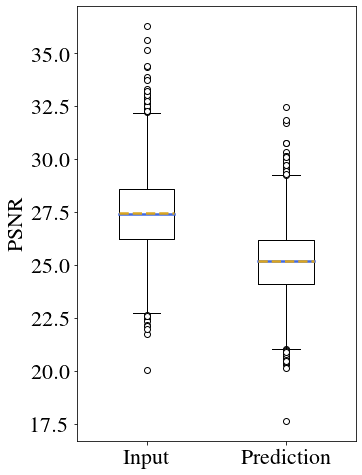

In [33]:
plt.figure(figsize=(5,8))
plt.boxplot(lowres_psnrs, positions=[0.5], labels=['Input'], widths=[.4], flierprops=flierprops, 
            showmeans=True, meanline=True, notch=False, meanprops=meanlineprops, medianprops=medianlineprops);
plt.boxplot(pred_psnrs, positions=[1.5], labels=['Prediction'], widths=[.4], flierprops=flierprops, 
            showmeans=True, meanline=True, notch=False, meanprops=meanlineprops, medianprops=medianlineprops);
plt.ylabel('PSNR');

In [34]:
fscs = []
fscs_pred = []
ress_pred = []
for i in range(len(lowres)):
    fsc, x, res = FSC(model, lowres[i], gt[i])
    fsc_pred, _, res_pred = FSC(model, pred_img[i], gt[i])
    fscs.append(fsc)
    fscs_pred.append(fsc_pred)
    ress_pred.append(res_pred)

ress_pred = np.stack(ress_pred)
avg_fsc = np.mean(np.stack(fscs), axis=0)
avg_fsc_pred = np.mean(np.stack(fscs_pred), axis=0)

findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


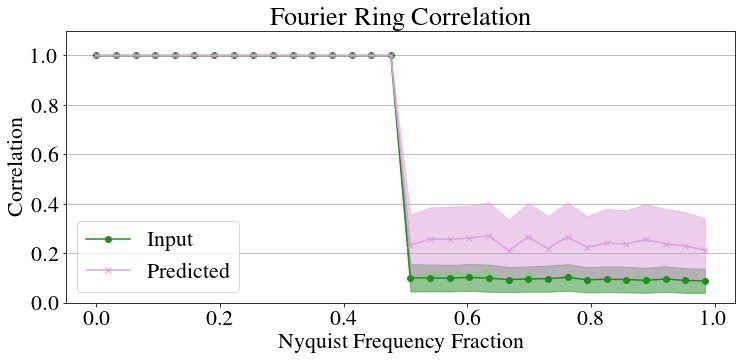

In [35]:
plt.figure(figsize=(12,5))
plt.plot(x[:len(fsc)], avg_fsc, '-o', color='forestgreen', label='Input')
std_fsc = np.std(np.stack(fscs), axis=0)
plt.fill_between(x[:len(fsc)], avg_fsc + std_fsc, avg_fsc - std_fsc, color='forestgreen', alpha=0.5)

std_fsc_pred = np.std(np.stack(fscs_pred), axis=0)
plt.plot(x[:len(fsc_pred)], avg_fsc_pred, '-x', color='plum', label='Predicted')
plt.fill_between(x[:len(fsc)], avg_fsc_pred + std_fsc_pred, avg_fsc_pred - std_fsc_pred, color='plum', alpha=0.5)
plt.ylim([0,1.1]);
plt.xticks(np.linspace(0, 0.5, 6, endpoint=True), np.linspace(0,1,6, endpoint=True))
plt.grid(axis='y')
plt.legend(loc='lower left');
plt.title('Fourier Ring Correlation');
plt.ylabel('Correlation');
plt.xlabel('Nyquist Frequency Fraction');

In [36]:
pred_psnr_order = np.argsort(pred_psnrs)

worst = pred_psnr_order[99]
med = pred_psnr_order[2499]
best = pred_psnr_order[-100]

In [37]:
diag = np.ones((63,63), dtype=np.bool)
xc, yc = np.meshgrid(range(63), range(63))
diag[xc + yc < 63] = 0

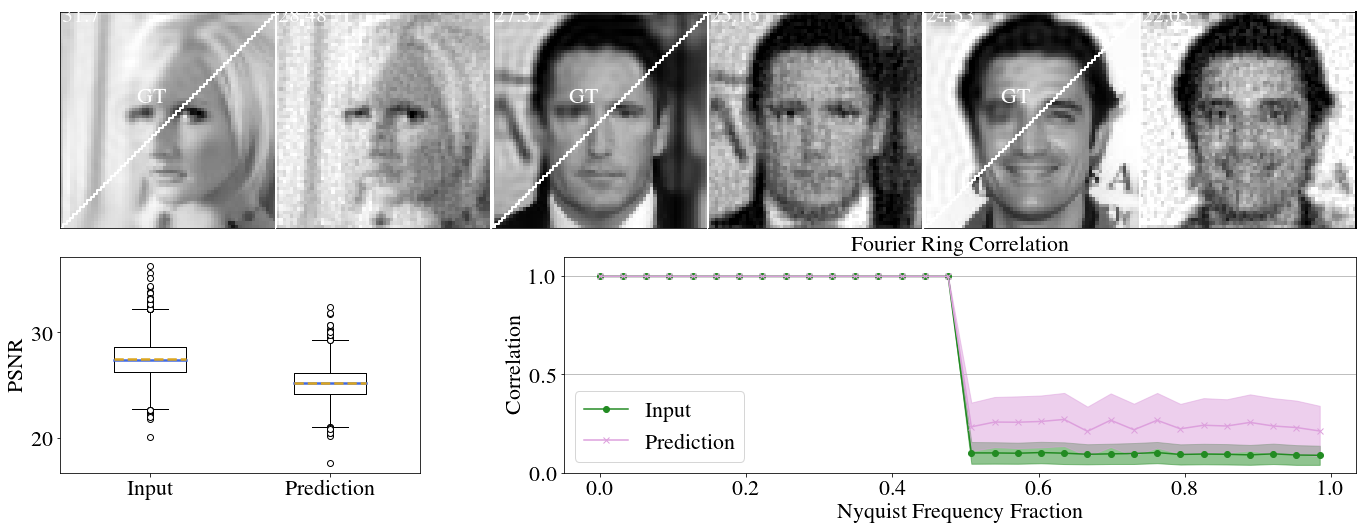

In [38]:
fig = plt.figure(figsize=(18, 6.4) )
gs = gridspec.GridSpec(3, 18, width_ratios=18*[1,], height_ratios=[3, .4, 3]) 
spacer = plt.subplot(gs[1,:])
ax0 = plt.subplot(gs[2,:5])
ax1 = plt.subplot(gs[2,5:7])
ax2_1 = plt.subplot(gs[0,:3])
ax2_2 = plt.subplot(gs[0,3:6])
ax2_3 = plt.subplot(gs[0,6:9])
ax2_4 = plt.subplot(gs[0,9:12])
ax2_5 = plt.subplot(gs[0,12:15])
ax2_6 = plt.subplot(gs[0,15:])
ax3 = plt.subplot(gs[2,7:])

plt.subplots_adjust(top = 1, bottom = 0, right = 1, left = 0, 
                    hspace = 0., wspace = 0.0)

ax0.boxplot(lowres_psnrs, positions=[0.5], labels=['Input'], widths=[.4], flierprops=flierprops, 
            showmeans=True, meanline=True, notch=False, meanprops=meanlineprops, medianprops=medianlineprops);
ax0.boxplot(pred_psnrs, positions=[1.5], labels=['Prediction'], widths=[.4], flierprops=flierprops, 
            showmeans=True, meanline=True, notch=False, meanprops=meanlineprops, medianprops=medianlineprops);
ax0.set_ylabel('PSNR', fontsize=22);

ax1.xaxis.set_major_locator(plt.NullLocator())
ax1.yaxis.set_major_locator(plt.NullLocator())
ax1.axis('off');

spacer.xaxis.set_major_locator(plt.NullLocator())
spacer.yaxis.set_major_locator(plt.NullLocator())
spacer.axis('off');

mixed = np.array(lowres[best])
mixed[diag] = np.array(gt[best])[diag]
# mixed[xc+yc == 26] = mixed.max()
ax2_1.imshow(mixed, cmap='gray', vmin=gt[best].min(), vmax=gt[best].max())
# ax2_1.plot([-0.3,26.5],[26.5,-0.3],color='white',linewidth=5)
ax2_1.plot(np.stack(2*[np.arange(64),],-1).flatten()[1:-1] - 0.5, 
           np.stack(2*[np.arange(62,-1,-1),],-1).flatten() + 0.5, color='white', linewidth=2)
ax2_1.xaxis.set_major_locator(plt.NullLocator())
ax2_1.yaxis.set_major_locator(plt.NullLocator())
ax2_1.text(0.3,2.3, np.round(lowres_psnrs[best], 2), color='white')
ax2_1.text(22.1,26, 'GT', color='white')
ax2_2.imshow(pred_img[best], cmap='gray', vmin=gt[best].min(), vmax=gt[best].max())
ax2_2.xaxis.set_major_locator(plt.NullLocator())
ax2_2.yaxis.set_major_locator(plt.NullLocator())
ax2_2.text(0.3,2.3, np.round(pred_psnrs[best], 2), color='white')
ax2_2.axes.spines["left"].set_color("white")
ax2_2.axes.spines["left"].set_linewidth(2)
ax2_2.axes.spines["right"].set_color("white")
ax2_2.axes.spines["right"].set_linewidth(4)

mixed = np.array(lowres[med])
mixed[diag] = np.array(gt[med])[diag]
# mixed[xc+yc == 26] = mixed.max()
ax2_3.imshow(mixed, cmap='gray', vmin=gt[med].min(), vmax=gt[med].max())
# ax2_3.plot([-0.3,26.5],[26.5,-0.3],color='white',linewidth=5)
ax2_3.plot(np.stack(2*[np.arange(64),],-1).flatten()[1:-1] - 0.5, 
           np.stack(2*[np.arange(62,-1,-1),],-1).flatten() + 0.5, color='white', linewidth=2)
ax2_3.xaxis.set_major_locator(plt.NullLocator())
ax2_3.yaxis.set_major_locator(plt.NullLocator())
ax2_3.text(0.3,2.3, np.round(lowres_psnrs[med], 2), color='white')
ax2_3.text(22.1,26, 'GT', color='white')
ax2_3.axes.spines["left"].set_color("white")
ax2_3.axes.spines["left"].set_linewidth(4)
ax2_3.axes.spines["right"].set_color("white")
ax2_3.axes.spines["right"].set_linewidth(2)
ax2_4.imshow(pred_img[med], cmap='gray', vmin=gt[med].min(), vmax=gt[med].max())
ax2_4.xaxis.set_major_locator(plt.NullLocator())
ax2_4.yaxis.set_major_locator(plt.NullLocator())
ax2_4.text(0.3,2.3, np.round(pred_psnrs[med], 2), color='white')
ax2_4.axes.spines["left"].set_color("white")
ax2_4.axes.spines["left"].set_linewidth(2)
ax2_4.axes.spines["right"].set_color("white")
ax2_4.axes.spines["right"].set_linewidth(4)

mixed = np.array(lowres[worst])
mixed[diag] = np.array(gt[worst])[diag]
# mixed[xc+yc == 26] = mixed.max()
ax2_5.imshow(mixed, cmap='gray', vmin=gt[worst].min(), vmax=gt[worst].max())
# ax2_5.plot([-0.3,26.5],[26.5,-0.3],color='white',linewidth=5)
ax2_5.plot(np.stack(2*[np.arange(64),],-1).flatten()[1:-1] - 0.5, 
           np.stack(2*[np.arange(62,-1,-1),],-1).flatten() + 0.5, color='white', linewidth=2)
ax2_5.xaxis.set_major_locator(plt.NullLocator())
ax2_5.yaxis.set_major_locator(plt.NullLocator())
ax2_5.text(0.3,2.3, np.round(lowres_psnrs[worst], 2), color='white')
ax2_5.text(22.1,26, 'GT', color='white')
ax2_5.axes.spines["left"].set_color("white")
ax2_5.axes.spines["left"].set_linewidth(4)
ax2_5.axes.spines["right"].set_color("white")
ax2_5.axes.spines["right"].set_linewidth(2)
ax2_6.imshow(pred_img[worst], cmap='gray', vmin=gt[worst].min(), vmax=gt[worst].max())
ax2_6.xaxis.set_major_locator(plt.NullLocator())
ax2_6.yaxis.set_major_locator(plt.NullLocator())
ax2_6.text(0.3,2.3, np.round(pred_psnrs[worst], 2), color='white')
ax2_6.axes.spines["left"].set_color("white")
ax2_6.axes.spines["right"].set_linewidth(2)

ax3.plot(x[:len(fsc)], avg_fsc, '-o', color='forestgreen', label='Input')
std_fsc = np.std(np.stack(fscs), axis=0)
ax3.fill_between(x[:len(fsc)], avg_fsc + std_fsc, avg_fsc - std_fsc, color='forestgreen', alpha=0.5)

std_fsc_pred = np.std(np.stack(fscs_pred), axis=0)
ax3.plot(x[:len(fsc_pred)], avg_fsc_pred, '-x', color='plum', label='Prediction')
ax3.fill_between(x[:len(fsc)], avg_fsc_pred + std_fsc_pred, avg_fsc_pred - std_fsc_pred, color='plum', alpha=0.5)
ax3.set_ylim([0,1.1]);
ax3.set_xticks(np.linspace(0, 0.5, 6, endpoint=True))
ax3.set_xticklabels(np.linspace(0,1,6, endpoint=True))
ax3.grid(axis='y')
ax3.legend(loc='lower left');
ax3.set_title('Fourier Ring Correlation', fontsize=22);
ax3.set_ylabel('Correlation');
ax3.set_xlabel('Nyquist Frequency Fraction');
fig.savefig('figures/sres/sres_celeb_quantitative.pdf', bbox_inches='tight', pad_inches=0.0)

# low-high sequence

In [39]:
x, y = np.meshgrid(range(model.dft_shape[1]), range(-model.dft_shape[0] // 2, model.dft_shape[0] // 2))
radii = np.roll(np.sqrt(x ** 2 + y ** 2, dtype=np.float32), model.dft_shape[0] // 2, 0)

In [40]:
sample = 32

In [41]:
from scipy.ndimage.filters import median_filter

In [42]:
lrs = []
pis = []
gts = []
for sample in [32, 134, 743]:
    for num_shells in [2, 4, 8, 16]:
        model.input_seq_length = np.sum(np.round(radii) < num_shells)

        model = model.cuda()

        lowres, pred_img, gt = model.get_lowres_pred_gt(fc[sample].cuda().unsqueeze(0), 
                                                        mag_min[sample].cuda().unsqueeze(0), 
                                                        mag_max[sample].cuda().unsqueeze(0))
        lrs.append(lowres)
        pis.append(pred_img)
        gts.append(gt)

/home/tbuchhol/.local/lib/python3.7/site-packages/torch/nn/functional.py:1628: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


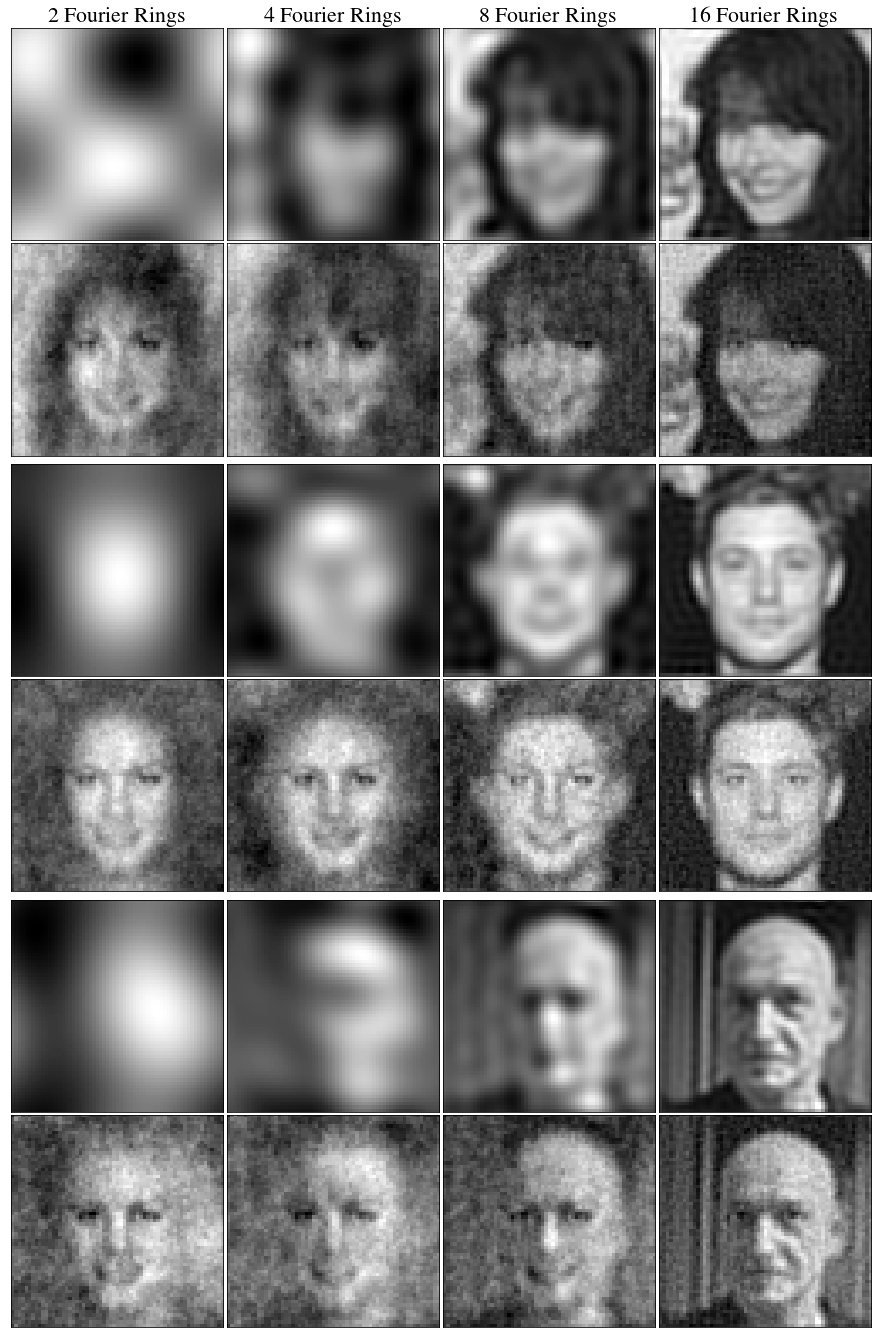

In [43]:
fig = plt.figure(figsize=(12, 18.18) )
gs = gridspec.GridSpec(9, 4, width_ratios=4*[3,], height_ratios=[0.1,3,3,0.04,3,3,0.04,3,3]) 

title_0 = plt.subplot(gs[0,0])
title_1 = plt.subplot(gs[0,1])
title_2 = plt.subplot(gs[0,2])
title_3 = plt.subplot(gs[0,3])

ax0_0 = plt.subplot(gs[1,0])
ax0_1 = plt.subplot(gs[1,1])
ax0_2 = plt.subplot(gs[1,2])
ax0_3 = plt.subplot(gs[1,3])

ax1_0 = plt.subplot(gs[2,0])
ax1_1 = plt.subplot(gs[2,1])
ax1_2 = plt.subplot(gs[2,2])
ax1_3 = plt.subplot(gs[2,3])

spacer_0 = plt.subplot(gs[3,:])
spacer_0.xaxis.set_major_locator(plt.NullLocator())
spacer_0.yaxis.set_major_locator(plt.NullLocator())
spacer_0.axis('off');

ax2_0 = plt.subplot(gs[4,0])
ax2_1 = plt.subplot(gs[4,1])
ax2_2 = plt.subplot(gs[4,2])
ax2_3 = plt.subplot(gs[4,3])

ax3_0 = plt.subplot(gs[5,0])
ax3_1 = plt.subplot(gs[5,1])
ax3_2 = plt.subplot(gs[5,2])
ax3_3 = plt.subplot(gs[5,3])

spacer_1 = plt.subplot(gs[6,:])
spacer_1.xaxis.set_major_locator(plt.NullLocator())
spacer_1.yaxis.set_major_locator(plt.NullLocator())
spacer_1.axis('off');

ax4_0 = plt.subplot(gs[7,0])
ax4_1 = plt.subplot(gs[7,1])
ax4_2 = plt.subplot(gs[7,2])
ax4_3 = plt.subplot(gs[7,3])

ax5_0 = plt.subplot(gs[8,0])
ax5_1 = plt.subplot(gs[8,1])
ax5_2 = plt.subplot(gs[8,2])
ax5_3 = plt.subplot(gs[8,3])

plt.subplots_adjust(top = 1, bottom = 0, right = 1, left = 0, 
                    hspace = 0.02, wspace = 0.0)

title_0.xaxis.set_major_locator(plt.NullLocator())
title_0.yaxis.set_major_locator(plt.NullLocator())
title_0.axis('off');
title_0.text(0.5, 0.5, '2 Fourier Rings', ha='center')

title_1.xaxis.set_major_locator(plt.NullLocator())
title_1.yaxis.set_major_locator(plt.NullLocator())
title_1.axis('off');
title_1.text(0.5, 0.5, '4 Fourier Rings', ha='center')

title_2.xaxis.set_major_locator(plt.NullLocator())
title_2.yaxis.set_major_locator(plt.NullLocator())
title_2.axis('off');
title_2.text(0.5, 0.5, '8 Fourier Rings', ha='center')

title_3.xaxis.set_major_locator(plt.NullLocator())
title_3.yaxis.set_major_locator(plt.NullLocator())
title_3.axis('off');
title_3.text(0.5, 0.5, '16 Fourier Rings', ha='center')

ax0_0.xaxis.set_major_locator(plt.NullLocator())
ax0_0.yaxis.set_major_locator(plt.NullLocator())
ax0_0.imshow(lrs[0].detach().cpu()[0], cmap='gray')

ax0_1.xaxis.set_major_locator(plt.NullLocator())
ax0_1.yaxis.set_major_locator(plt.NullLocator())
ax0_1.imshow(lrs[1].detach().cpu()[0], cmap='gray')

ax0_2.xaxis.set_major_locator(plt.NullLocator())
ax0_2.yaxis.set_major_locator(plt.NullLocator())
ax0_2.imshow(lrs[2].detach().cpu()[0], cmap='gray')

ax0_3.xaxis.set_major_locator(plt.NullLocator())
ax0_3.yaxis.set_major_locator(plt.NullLocator())
ax0_3.imshow(lrs[3].detach().cpu()[0], cmap='gray')

ax1_0.xaxis.set_major_locator(plt.NullLocator())
ax1_0.yaxis.set_major_locator(plt.NullLocator())
ax1_0.imshow(pis[0].detach().cpu()[0], cmap='gray')

ax1_1.xaxis.set_major_locator(plt.NullLocator())
ax1_1.yaxis.set_major_locator(plt.NullLocator())
ax1_1.imshow(pis[1].detach().cpu()[0], cmap='gray')

ax1_2.xaxis.set_major_locator(plt.NullLocator())
ax1_2.yaxis.set_major_locator(plt.NullLocator())
ax1_2.imshow(pis[2].detach().cpu()[0], cmap='gray')

ax1_3.xaxis.set_major_locator(plt.NullLocator())
ax1_3.yaxis.set_major_locator(plt.NullLocator())
ax1_3.imshow(pis[3].detach().cpu()[0], cmap='gray')


ax2_0.xaxis.set_major_locator(plt.NullLocator())
ax2_0.yaxis.set_major_locator(plt.NullLocator())
ax2_0.imshow(lrs[4].detach().cpu()[0], cmap='gray')

ax2_1.xaxis.set_major_locator(plt.NullLocator())
ax2_1.yaxis.set_major_locator(plt.NullLocator())
ax2_1.imshow(lrs[5].detach().cpu()[0], cmap='gray')

ax2_2.xaxis.set_major_locator(plt.NullLocator())
ax2_2.yaxis.set_major_locator(plt.NullLocator())
ax2_2.imshow(lrs[6].detach().cpu()[0], cmap='gray')

ax2_3.xaxis.set_major_locator(plt.NullLocator())
ax2_3.yaxis.set_major_locator(plt.NullLocator())
ax2_3.imshow(lrs[7].detach().cpu()[0], cmap='gray')

ax3_0.xaxis.set_major_locator(plt.NullLocator())
ax3_0.yaxis.set_major_locator(plt.NullLocator())
ax3_0.imshow(pis[4].detach().cpu()[0], cmap='gray')

ax3_1.xaxis.set_major_locator(plt.NullLocator())
ax3_1.yaxis.set_major_locator(plt.NullLocator())
ax3_1.imshow(pis[5].detach().cpu()[0], cmap='gray')

ax3_2.xaxis.set_major_locator(plt.NullLocator())
ax3_2.yaxis.set_major_locator(plt.NullLocator())
ax3_2.imshow(pis[6].detach().cpu()[0], cmap='gray')

ax3_3.xaxis.set_major_locator(plt.NullLocator())
ax3_3.yaxis.set_major_locator(plt.NullLocator())
ax3_3.imshow(pis[7].detach().cpu()[0], cmap='gray')


ax4_0.xaxis.set_major_locator(plt.NullLocator())
ax4_0.yaxis.set_major_locator(plt.NullLocator())
ax4_0.imshow(lrs[8].detach().cpu()[0], cmap='gray')

ax4_1.xaxis.set_major_locator(plt.NullLocator())
ax4_1.yaxis.set_major_locator(plt.NullLocator())
ax4_1.imshow(lrs[9].detach().cpu()[0], cmap='gray')

ax4_2.xaxis.set_major_locator(plt.NullLocator())
ax4_2.yaxis.set_major_locator(plt.NullLocator())
ax4_2.imshow(lrs[10].detach().cpu()[0], cmap='gray')

ax4_3.xaxis.set_major_locator(plt.NullLocator())
ax4_3.yaxis.set_major_locator(plt.NullLocator())
ax4_3.imshow(lrs[11].detach().cpu()[0], cmap='gray')

ax5_0.xaxis.set_major_locator(plt.NullLocator())
ax5_0.yaxis.set_major_locator(plt.NullLocator())
ax5_0.imshow(pis[8].detach().cpu()[0], cmap='gray')

ax5_1.xaxis.set_major_locator(plt.NullLocator())
ax5_1.yaxis.set_major_locator(plt.NullLocator())
ax5_1.imshow(pis[9].detach().cpu()[0], cmap='gray')

ax5_2.xaxis.set_major_locator(plt.NullLocator())
ax5_2.yaxis.set_major_locator(plt.NullLocator())
ax5_2.imshow(pis[10].detach().cpu()[0], cmap='gray')

ax5_3.xaxis.set_major_locator(plt.NullLocator())
ax5_3.yaxis.set_major_locator(plt.NullLocator())
ax5_3.imshow(pis[11].detach().cpu()[0], cmap='gray')


fig.savefig('figures/sres/sres_celeb_conditioning.pdf', bbox_inches='tight', pad_inches=0.0)